In [37]:
import xarray as xr
import rioxarray
import geopandas as gpd
from landlab.grid import RasterModelGrid
from landlab.components import OverlandFlow
from landlab.components import CRESTHH
import matplotlib.pyplot as plt
from landlab.io import read_geotif
from landlab.grid.mappers import map_mean_of_link_nodes_to_link

In [6]:
basin_shp= gpd.read_file('/Users/allen/OneDrive - University of Oklahoma/CRESTHH/subbasins/08076700.shp',
                         crs='EPSG:4326')
basin_shp= basin_shp.set_crs('EPSG:4326')
basin_shp= basin_shp.to_crs('EPSG:32215')

In [7]:
dem_region= rioxarray.open_rasterio('/Users/allen/OneDrive - University of Oklahoma/CRESTHH/Case study - Harvey/demHouston033s_NAm83.tif/demHouston033s_NAm83.tif')
dem_region= dem_region.rio.write_crs('EPSG:4326')
dem_region= dem_region.rio.reproject('EPSG:32215')

In [8]:
basin_dem= dem_region.rio.clip(basin_shp.geometry, basin_shp.crs).squeeze().sortby('y', ascending=True)

In [10]:
basin= RasterModelGrid(shape= basin_dem.squeeze().shape,
                       xy_spacing=np.diff(basin_dem.x.values)[0],
                       xy_of_lower_left= [basin_dem.x.values[0], basin_dem.y.values[0]]
                      )

In [11]:
z= basin.add_field('topographic__elevation', basin_dem.values, at="node", clobber=True)

In [12]:
def load_param(path, lons=basin_dem.x.values, lats=basin_dem.y.values):
    param= rioxarray.open_rasterio(path)
    param= param.rio.write_crs('EPSG:4326').rio.reproject('EPSG:32215')
    param= param.sel(x= lons, y=lats, method='nearest')
    return param.values
    

In [13]:
from landlab import imshow_grid_at_node

In [14]:
basin.status_at_node[basin.nodes_at_bottom_edge] = basin.BC_NODE_IS_FIXED_VALUE
basin.status_at_node[np.isclose(z, basin_dem._FillValue)] = basin.BC_NODE_IS_CLOSED

/Users/allen/Documents/Python/landlab/landlab/plot/imshow.py:267: MatplotlibDeprecationWarning: You are modifying the state of a globally registered colormap. In future versions, you will not be able to modify a registered colormap in-place. To remove this warning, you can make a copy of the colormap first. cmap = copy.copy(mpl.cm.get_cmap("terrain"))
  cmap.set_bad(color=color_for_closed)
/Users/allen/Documents/Python/landlab/landlab/plot/imshow.py:307: MatplotlibDeprecationWarning: The 'norm' parameter to Colorbar has no effect because it is overridden by the mappable; it is deprecated since 3.3 and will be removed two minor releases later.
  cb = plt.colorbar(norm=norm, shrink=shrink)
/Users/allen/miniconda3/envs/landlab_dev/lib/python3.9/site-packages/matplotlib/colors.py:576: RuntimeWarning: overflow encountered in multiply
  xa *= self.N


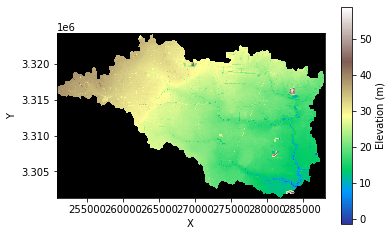

In [15]:
fig= plt.figure()
imshow_grid_at_node(basin, z, colorbar_label='Elevation (m)', cmap='terrain')
plt.show();

In [16]:
param= load_param('/Users/allen/OneDrive - University of Oklahoma/CRESTHH/data/CREST_para/b_10m.tif')
_= basin.add_field('B', param, at="node", dtype=np.float32)
param= load_param('/Users/allen/OneDrive - University of Oklahoma/CRESTHH/data/CREST_para/wm_10m.tif')
_= basin.add_field('WM', param, at="node", units='mm',clobber=True, dtype=np.float32)
param= load_param('/Users/allen/OneDrive - University of Oklahoma/CRESTHH/data/CREST_para/ksat.tif')
_= basin.add_field('Ksat', param, at="node", units='mm/hr',clobber=True, dtype=np.float32)
param= load_param('/Users/allen/OneDrive - University of Oklahoma/CRESTHH/data/CREST_para/im.tif')
_= basin.add_field('IM', param, at="node", units='%',clobber=True, dtype=np.float32)
param= load_param('/Users/allen/OneDrive - University of Oklahoma/CRESTHH/data/sm.20170826.120000.tif')
_= basin.add_field('SM0', param, at="node", units='%',clobber=True, dtype=np.float32)
param= load_param('/Users/allen/OneDrive - University of Oklahoma/CRESTHH/data/friction/manningn.tif')
_= basin.add_field('friction_node', param, at="node",clobber=True, dtype=np.float32)
friction_link= map_mean_of_link_nodes_to_link(basin, 'friction_node')

array([ 5.33,  5.33,  5.33, ...,  4.74,  4.74,  4.74], dtype=float32)

array([ 192. ,  192. ,  192. , ...,   19.5,   19.5,   19.5], dtype=float32)

array([ 9.,  9.,  9., ...,  2.,  2.,  2.], dtype=float32)

array([ 0.,  0.,  0., ...,  5.,  5.,  5.], dtype=float32)

array([ 45.,  45.,  45., ...,  31.,  31.,  31.], dtype=float32)

array([ 0.36  ,  0.36  ,  0.36  , ...,  0.0404,  0.0404,  0.0404], dtype=float32)

In [17]:
_= basin.add_field('friction', friction_link.astype(np.float32), at="link",clobber=True, units='-')

In [18]:
_= basin.add_ones('KE',at='node', dtype= np.float32,clobber=True)

In [38]:
cresthh= CRESTHH(basin, proj='EPSG:32215',
                start= '20170825000000',
                end= '20170830000000',
                freq= '15T',
                precip_path='/Users/allen/OneDrive - University of Oklahoma/CRESTHH/data/mrms201708/',
                precip_freq='2T',
                precip_pattern='PrecipRate_00.00_%Y%m%d-%H%M%S.grib2-var0-z0.tif',
                evap_path= '/Users/allen/OneDrive - University of Oklahoma/CRESTHH/data/evap/',
                evap_freq='1D',
                evap_pattern= 'cov_et%y%m%d.asc.tif',
                parallel=4)


In [39]:
cresthh.run()

(10, 10063328)
(4, 10063328)


KeyboardInterrupt: 

In [200]:
2000.5%2000

0.5

In [199]:
pd.Timedelta('1D').total_seconds()

86400.0

In [170]:
from datetime import datetime

In [175]:
(pd.to_datetime('20170825000000') - pd.to_datetime('19700101000000')).total_seconds()

1503619200.0